In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('C:/Users/elley/Desktop/Python/project_4_portfolio/mart_codeit/EDA4_finsish.csv')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df.head(3)

,ID,signup_ym,birth_year,annual_income,matrimony,children,recency,amount_alcohol,amount_fruit,amount_meat,amount_fish,amount_snack,amount_general,amount_total,num_purchase_web,num_purchase_store,num_purchase_discount,num_purchase_total,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,age,recency_grade,frequency_grade,monetary_grade,rfm_score,rfm_segment,age_group
0,5524,2020-12,1965,75579400.0,미혼,0,58,825500,114400,709800,223600,114400,114400,2102100,8,4,3,15,0,0,0,0,0,1,59,2,2,3,2.4,3,50대
1,2174,2022-06,1962,60247200.0,미혼,2,38,14300,1300,7800,2600,1300,7800,35100,1,2,2,5,0,0,0,0,0,0,62,2,1,1,1.2,1,60대
2,4141,2021-11,1973,93096900.0,배우자 있음,0,26,553800,63700,165100,144300,27300,54600,1008800,8,10,1,19,0,0,0,0,0,0,51,3,3,2,2.6,3,50대


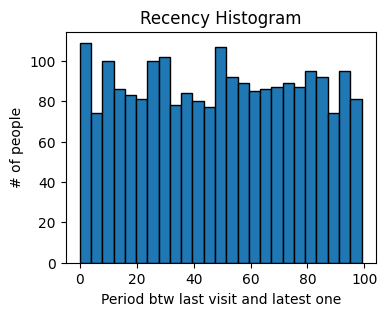

In [7]:
# RFM 세 지표의 분포를 확인하고 치우친 분포는 로그변환을 시켜서 정규분포와 비슷한 형태를 띄게 한다.
plt.figure(figsize=(4, 3))
plt.hist(df['recency'], bins = 25, edgecolor='black')
plt.title('Recency Histogram')
plt.xlabel('Period btw last visit and latest one')
plt.ylabel('# of people')
plt.show()

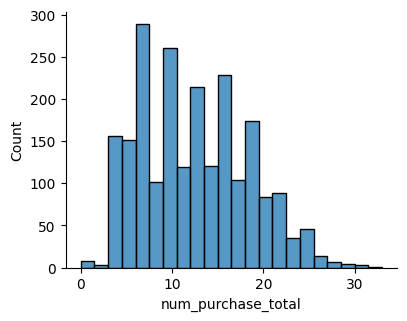

In [8]:
f=sns.displot(df['num_purchase_total'])
f.fig.set_size_inches(4, 3)
plt.show()

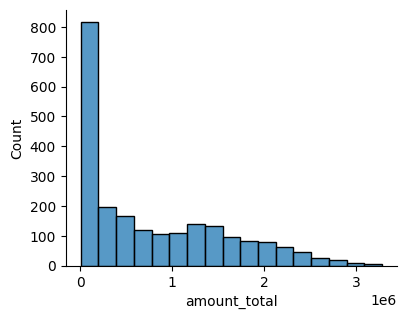

In [9]:
m=sns.displot(df['amount_total'])
m.fig.set_size_inches(4, 3)
plt.show()

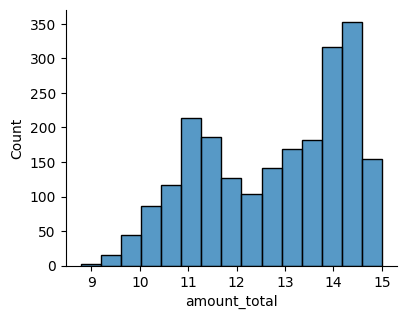

In [10]:
# Monetary는 로그변환을 통해 분포를 정규분포에 가깝게 만들어준다.
monetary_log = np.log(df['amount_total'])
m_1=sns.displot(monetary_log)
m_1.fig.set_size_inches(4, 3)
plt.show()

In [11]:
df['monetary_log'] = monetary_log

### Min-max scaling 한 후 clustering

In [12]:
# RFM에 필요한 컬럼들만 추출하여 따로 데이터프레임을 만든다.
rfm = df[['recency', 'num_purchase_total', 'monetary_log']]

In [13]:
# 최소값이 0, 최대값이 1인 MinMaxScaler 사용
scaler = MinMaxScaler()

In [14]:
# Fit and transform the data (train data와 test data를 따로 지정하지 않았음)
scaled_data = scaler.fit_transform(rfm)

In [15]:
# Convert the scaled data back into a DataFrame (optional)
scaled_rfm = pd.DataFrame(scaled_data, columns=rfm.columns)

In [16]:
scaled_rfm.describe()

,recency,num_purchase_total,monetary_log
count,2213.000000,2213.000000,2213.000000
mean,0.495027,0.370250,0.643293
std,0.292342,0.177581,0.238243
min,0.000000,0.000000,0.000000
25%,0.242424,0.212121,0.421663
50%,0.494949,0.363636,0.702781
75%,0.747475,0.515152,0.858728
max,1.000000,1.000000,1.000000


In [17]:
# recency 값 역전시키기
inverted_recency = 1 - scaled_rfm['recency']

In [18]:
scaled_rfm['inverted_recency'] = inverted_recency

In [19]:
scaled_rfm.head(3)

,recency,num_purchase_total,monetary_log,inverted_recency
0,0.585859,0.454545,0.928402,0.414141
1,0.383838,0.151515,0.270927,0.616162
2,0.262626,0.575758,0.810453,0.737374


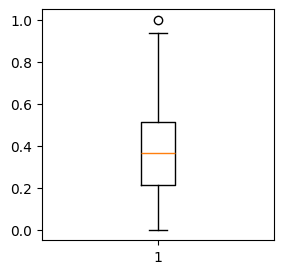

In [20]:
plt.figure(figsize=(3,3))
plt.boxplot(scaled_rfm['num_purchase_total'])
plt.show()

In [21]:
mod_scaled_rfm = scaled_rfm.drop('recency', axis=1)

In [22]:
from sklearn.cluster import KMeans 

In [23]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(mod_scaled_rfm)
    wcss.append(kmeans.inertia_)  # inertia는 WCSS 값

In [24]:
plt.rc('font', family='Malgun Gothic')

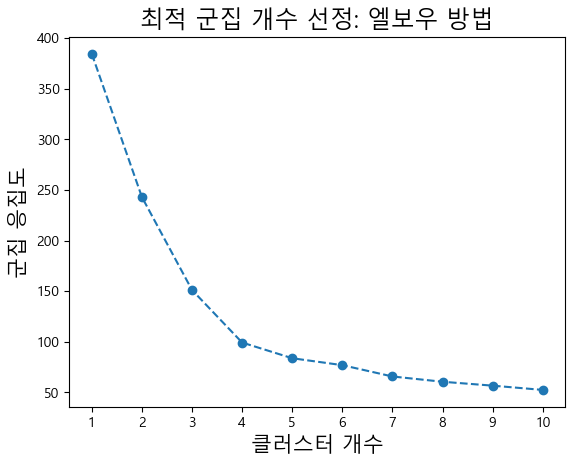

In [25]:
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('최적 군집 개수 선정: 엘보우 방법', fontsize = 17)
plt.xlabel('클러스터 개수', fontsize = 15)
plt.ylabel('군집 응집도', fontsize = 15)
plt.xticks(range(1, 11))
plt.show()

#### 3-4 기울기와 4-5기울기에서 차이가 나므로 군집을 4개로 하면 적당할 것 같음.

In [26]:
# 모델 학습
clust_model = KMeans(n_clusters = 4, max_iter = 50, random_state = 42) # 클러스터 갯수
# 생성한 모델로 데이터를 학습시킴
clust_model.fit(mod_scaled_rfm) # unsupervised learning 

KMeans(max_iter=50, n_clusters=4, random_state=42)

In [27]:
cluster_labels= clust_model.labels_

In [28]:
rfm_new = mod_scaled_rfm.assign(Cluster = cluster_labels)

In [29]:
rfm_new.head(3)

,num_purchase_total,monetary_log,inverted_recency,Cluster
0,0.454545,0.928402,0.414141,2
1,0.151515,0.270927,0.616162,3
2,0.575758,0.810453,0.737374,0


### ** 각 RFM 등급의 분포를 관찰

In [30]:
rfm_new.rename(columns={'num_purchase_total': 'Frequency', 'monetary_log': 'Monetary', 
                               'inverted_recency':'Recency'}, inplace=True)
# mod = mod_scaled_rfm.reset_index(drop = True)
rfm_new.head(2)

,Frequency,Monetary,Recency,Cluster
0,0.454545,0.928402,0.414141,2
1,0.151515,0.270927,0.616162,3


In [31]:
from matplotlib import font_manager, rc
import platform

In [32]:
if platform.system() == 'Windows':
    rc('font', family='Malgun Gothic')  

In [33]:
rfm_renew = rfm_new['Cluster'].replace({0:'High', 1:'Low', 2:'Middle_High', 3:'Middle_Low'})

In [34]:
rfm_new['cluster'] = rfm_new['Cluster'].replace({0:'High', 1:'Low', 2:'Middle_High', 3:'Middle_Low'})

In [35]:
rfm_new.head(3)

,Frequency,Monetary,Recency,Cluster,cluster
0,0.454545,0.928402,0.414141,2,Middle_High
1,0.151515,0.270927,0.616162,3,Middle_Low
2,0.575758,0.810453,0.737374,0,High


In [36]:
rfm_new.drop(['Cluster'], axis=1, inplace=True)

In [37]:
rfm_new.head(6)

,Frequency,Monetary,Recency,cluster
0,0.454545,0.928402,0.414141,Middle_High
1,0.151515,0.270927,0.616162,Middle_Low
2,0.575758,0.810453,0.737374,High
3,0.242424,0.379281,0.737374,Middle_Low
4,0.484848,0.712591,0.050505,Middle_High
5,0.545455,0.797525,0.838384,High


In [38]:
f = rfm_new[['Frequency', 'cluster']]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6184\1940818835.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Frequency', y='cluster', data=f, palette='Set2', orient='h')


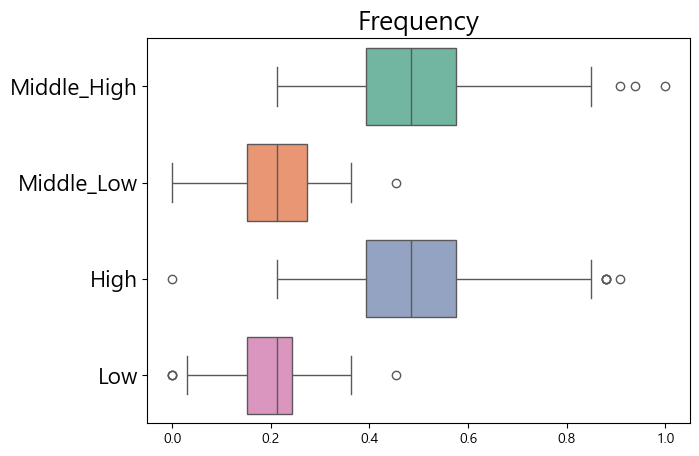

In [39]:
f = rfm_new[['Frequency', 'cluster']]

# 캔버스 크기 조절
plt.figure(figsize=(7, 5))

# 박스 플롯 그리기
# boxplot = f.boxplot(boxprops=dict(color='orange'), medianprops=dict(color='orange'),
# whiskerprops=dict(color='orange'), column='Frequency', by='Cluster', grid=False, vert=False)

sns.boxplot(x='Frequency', y='cluster', data=f, palette='Set2', orient='h')

# 제목 및 라벨 추가
plt.title('Frequency', fontsize = 19)
# plt.xlabel('Frequency', fontsize = 16)
plt.tick_params(axis='y', labelsize=16)
plt.ylabel('Frequency 등급', fontsize = 16)
plt.suptitle('') 
plt.xlabel('')
plt.ylabel('')

# new_category_names = ['1', '2', '3', '4']
# plt.gca().set_yticklabels(new_category_names)
# boxplot.set_yticklabels(new_category_names)
# 플롯 출력
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6184\3581561065.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Monetary', y='cluster', data=m, palette='Set2', orient='h')


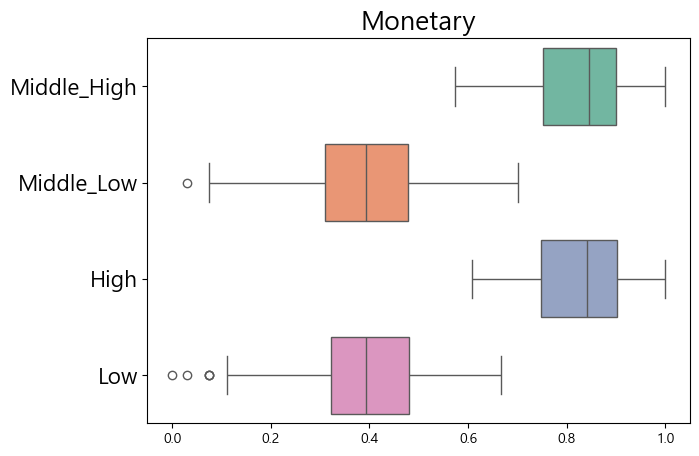

In [40]:
m = rfm_new[['Monetary', 'cluster']]

# 캔버스 크기 조절
plt.figure(figsize=(7, 5))

# 박스 플롯 그리기
# boxplot = m.boxplot(boxprops=dict(color='blue'), medianprops=dict(color='blue'),whiskerprops=dict(color='blue'),
# column='Monetary', by='Cluster', grid=False, vert=False)

sns.boxplot(x='Monetary', y='cluster', data=m, palette='Set2', orient='h')

# 제목 및 라벨 추가
plt.title('Monetary', fontsize = 19)
# plt.xlabel('Monetary',  fontsize = 16)
plt.ylabel('Monetary 등급', fontsize = 16)
plt.tick_params(axis='y', labelsize=16)
plt.suptitle('') 
plt.xlabel('')
plt.ylabel('')

#new_category_names = ['1', '2', '3', '4']
#plt.gca().set_yticklabels(new_category_names)
#boxplot.set_yticklabels(new_category_names)

# 플롯 출력
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6184\2648615078.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Recency', y='cluster', data=r, palette='Set2', orient='h')


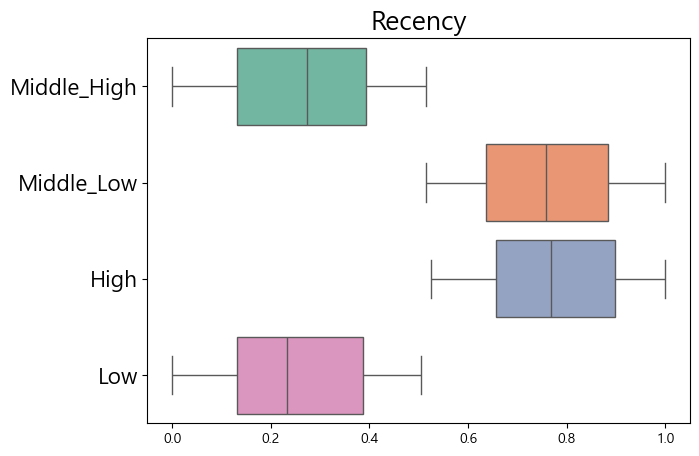

In [41]:
r = rfm_new[['Recency', 'cluster']]

# 캔버스 크기 조절
plt.figure(figsize=(7, 5))

# 박스 플롯 그리기
# boxplot = r.boxplot(boxprops=dict(color='magenta'), medianprops=dict(color='magenta'), 
# whiskerprops=dict(color='magenta'), column='Recency', by='Cluster', grid=False, vert=False)

sns.boxplot(x='Recency', y='cluster', data=r, palette='Set2', orient='h')

# 제목 및 라벨 추가
# 제목 및 라벨 추가
plt.title('Recency', fontsize = 19)
# plt.xlabel('Monetary',  fontsize = 16)
plt.ylabel('Recency 등급', fontsize = 16)
plt.tick_params(axis='y', labelsize=16)
plt.suptitle('') 
plt.xlabel('')
plt.ylabel('')

# new_category_names = ['1', '2', '3', '4']
# plt.gca().set_yticklabels(new_category_names)

plt.show()

In [42]:
mean_values = rfm_new.groupby('cluster').mean()
mean_values

,Frequency,Monetary,Recency
cluster,,,
High,0.494076,0.824391,0.771526
Low,0.204675,0.395915,0.254101
Middle_High,0.486895,0.824062,0.267106
Middle_Low,0.205314,0.392383,0.762419


In [43]:
count = rfm_new.groupby('cluster').size()
count

cluster
High           601
Low            468
Middle_High    681
Middle_Low     463
dtype: int64

In [44]:
rfm_count= pd.concat([mean_values, count], axis=1)

In [45]:
rfm_count

,Frequency,Monetary,Recency,0
cluster,,,,
High,0.494076,0.824391,0.771526,601
Low,0.204675,0.395915,0.254101,468
Middle_High,0.486895,0.824062,0.267106,681
Middle_Low,0.205314,0.392383,0.762419,463


In [46]:
rfm_count.rename(columns={0: '명수'}, inplace=True)

In [47]:
rfm_count

,Frequency,Monetary,Recency,명수
cluster,,,,
High,0.494076,0.824391,0.771526,601
Low,0.204675,0.395915,0.254101,468
Middle_High,0.486895,0.824062,0.267106,681
Middle_Low,0.205314,0.392383,0.762419,463


In [48]:
rfm_new.head(8)

,Frequency,Monetary,Recency,cluster
0,0.454545,0.928402,0.414141,Middle_High
1,0.151515,0.270927,0.616162,Middle_Low
2,0.575758,0.810453,0.737374,High
3,0.242424,0.379281,0.737374,Middle_Low
4,0.484848,0.712591,0.050505,Middle_High
5,0.545455,0.797525,0.838384,High
6,0.545455,0.766429,0.656566,High
7,0.303030,0.565576,0.676768,Middle_Low


In [49]:
rfm_new['cluster'] = rfm_new['cluster'].replace('Middle_High', 3)
rfm_new['cluster'] = rfm_new['cluster'].replace('Middle_Low', 2)
rfm_new['cluster'] = rfm_new['cluster'].replace('Low', 1)
rfm_new['cluster'] = rfm_new['cluster'].replace('High', 4)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6184\1608146281.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rfm_new['cluster'] = rfm_new['cluster'].replace('High', 4)


In [50]:
rfm_new.head(10)

,Frequency,Monetary,Recency,cluster
0,0.454545,0.928402,0.414141,3
1,0.151515,0.270927,0.616162,2
2,0.575758,0.810453,0.737374,4
3,0.242424,0.379281,0.737374,2
4,0.484848,0.712591,0.050505,3
5,0.545455,0.797525,0.838384,4
6,0.545455,0.766429,0.656566,4
7,0.303030,0.565576,0.676768,2
8,0.181818,0.356524,0.808081,2
9,0.060606,0.366674,0.313131,1


In [51]:
df = pd.concat([df, rfm_new], axis = 1)

In [52]:
df.head(2)

,ID,signup_ym,birth_year,annual_income,matrimony,children,recency,amount_alcohol,amount_fruit,amount_meat,amount_fish,amount_snack,amount_general,amount_total,num_purchase_web,num_purchase_store,num_purchase_discount,num_purchase_total,promotion_1,promotion_2,promotion_3,promotion_4,promotion_5,promotion_6,age,recency_grade,frequency_grade,monetary_grade,rfm_score,rfm_segment,age_group,monetary_log,Frequency,Monetary,Recency,cluster
0,5524,2020-12,1965,75579400.0,미혼,0,58,825500,114400,709800,223600,114400,114400,2102100,8,4,3,15,0,0,0,0,0,1,59,2,2,3,2.4,3,50대,14.558447,0.454545,0.928402,0.414141,3
1,2174,2022-06,1962,60247200.0,미혼,2,38,14300,1300,7800,2600,1300,7800,35100,1,2,2,5,0,0,0,0,0,0,62,2,1,1,1.2,1,60대,10.465956,0.151515,0.270927,0.616162,2


In [53]:
df.to_csv('cluster.csv', index=False)